In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-08-21 17:00:59 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-08-21 17:01:00 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-08-21 17:01:00 __main__ INFO     transformers.__version__='4.54.1'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-08-21 17:01:03 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-21 17:01:03 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-21 17:01:03 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-08-21 17:01:03 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-08-21 17:01:05 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-08-21 17:01:05 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443
2025-08-21 17:01:05 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-08-21 17:01:05 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-08-21 17:01:05 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-08-21 17:01:55 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-08-21 17:01:55 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-08-21 17:01:56 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
# file_path = os.path.join(
#     env_utils.DEFAULT_DATA_DIR,
#     "selection",
#     # "profession.json"
#     # "nationality.json"
#     "objects.json",
# )

# with open(file_path, "r") as f:
#     temp = json.load(f)

# for cat in temp["categories"]:
#     temp["categories"][cat] = [obj.capitalize() for obj in temp["categories"][cat]]

# with open(file_path, "w") as f:
#     json.dump(temp, f, indent=4)


In [6]:
from src.selection.data import SelectOneTask, SelectOrderTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

select_task.filter_single_token(mt.tokenizer, prefix=" ")
print(select_task)

SelectOneTask: (different objects)
Categories: fruit(11), vehicle(8), furniture(8), animal(13), music instrument(3), clothing(11), electronics(11), sport equipment(5), kitchen appliance(4), vegetable(5), building(14), office supply(8), bathroom item(7), flower(6), tree(10), jewelry(7)



In [7]:
sample = select_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    obj_idx=2,
    # category="actor",
    # category="Brazil"
    category="fruit",
    filter_by_lm_prediction=False,
)

print(sample)
print(sample.prompt())

Banana -> Orange (2): ['Guitar', 'Bat', 'Orange', 'Watch', 'Pen', 'Tie']
Options: Guitar, Bat, Orange, Watch, Pen, Tie.
Which among these objects mentioned above is a fruit?
Answer:


In [8]:
from src.selection.utils import verify_correct_option
# sample.prompt_template = select_prof.prompt_templates[3]
print(f'"{sample.prompt()}"', ">>", sample.obj)

verify_correct_option(
    mt=mt,
    target=sample.obj,
    options=sample.options,
    input=sample.prompt()
)

"Options: Guitar, Bat, Orange, Watch, Pen, Tie.
Which among these objects mentioned above is a fruit?
Answer:" >> Orange


(True,
 [PredictedToken(token=' Orange', prob=0.8203125, logit=22.375, token_id=22725, metadata=None),
  PredictedToken(token=' An', prob=0.0673828125, logit=19.875, token_id=1556, metadata=None),
  PredictedToken(token=' The', prob=0.0595703125, logit=19.75, token_id=578, metadata=None),
  PredictedToken(token=' Among', prob=0.0218505859375, logit=18.75, token_id=22395, metadata=None),
  PredictedToken(token=' orange', prob=0.005523681640625, logit=17.375, token_id=19087, metadata=None)],
 OrderedDict([(22725,
               (1,
                PredictedToken(token=' Orange', prob=0.8203125, logit=22.375, token_id=22725, metadata=None))),
              (16488,
               (55,
                PredictedToken(token=' Bat', prob=4.792213439941406e-05, logit=12.625, token_id=16488, metadata=None))),
              (13597,
               (117,
                PredictedToken(token=' Pen', prob=1.0669231414794922e-05, logit=11.125, token_id=13597, metadata=None))),
              (10573,
  

In [9]:
from src.functional import generate_with_patch

gen = generate_with_patch(
    mt = mt,
    inputs = sample.prompt(),
    max_new_tokens=20,
    do_sample=False,
    remove_prefix=True
)[0]
print(f'"{gen}"', ">>", sample.obj)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


" Orange. Orange is a fruit. The other options are not fruits. Guitar is a musical instrument," >> Orange


In [10]:
mt.n_layer, mt.config.num_attention_heads

(80, 64)

In [11]:
HEADS = [
    (33, 45),
    (33, 18),
    (34, 1),
    (34, 6),
    (34, 7),
    (35, 19),
    (39, 40),
    (42, 30),
    (47, 18),
    (52, 58),
]
# HEADS = [(35, 19)]


# with open("optimized_heads.json", "r") as f:
#     HEADS = json.load(f)

# with open("category_wise_heads.json", "r") as f:
#     category_wise_heads = json.load(f)
# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:100]
# ]
# HEADS = [(layer_idx, head_idx) for layer_idx, head_idx in HEADS if layer_idx < 61]


print(len(HEADS))

10


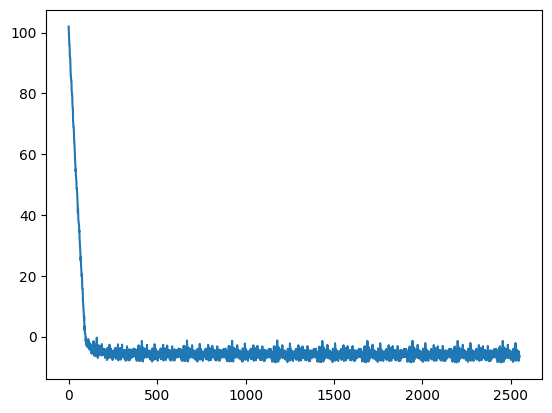

In [13]:
from matplotlib import pyplot as plt
import numpy as np

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection/optimized_heads",
#     mt.name.split("/")[-1],
#     f"{select_task.task_name}.npz"
# )

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    mt.name.split("/")[-1],
    f"{select_task.task_name}",
    "epoch_10.npz"
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

80


(True, True)

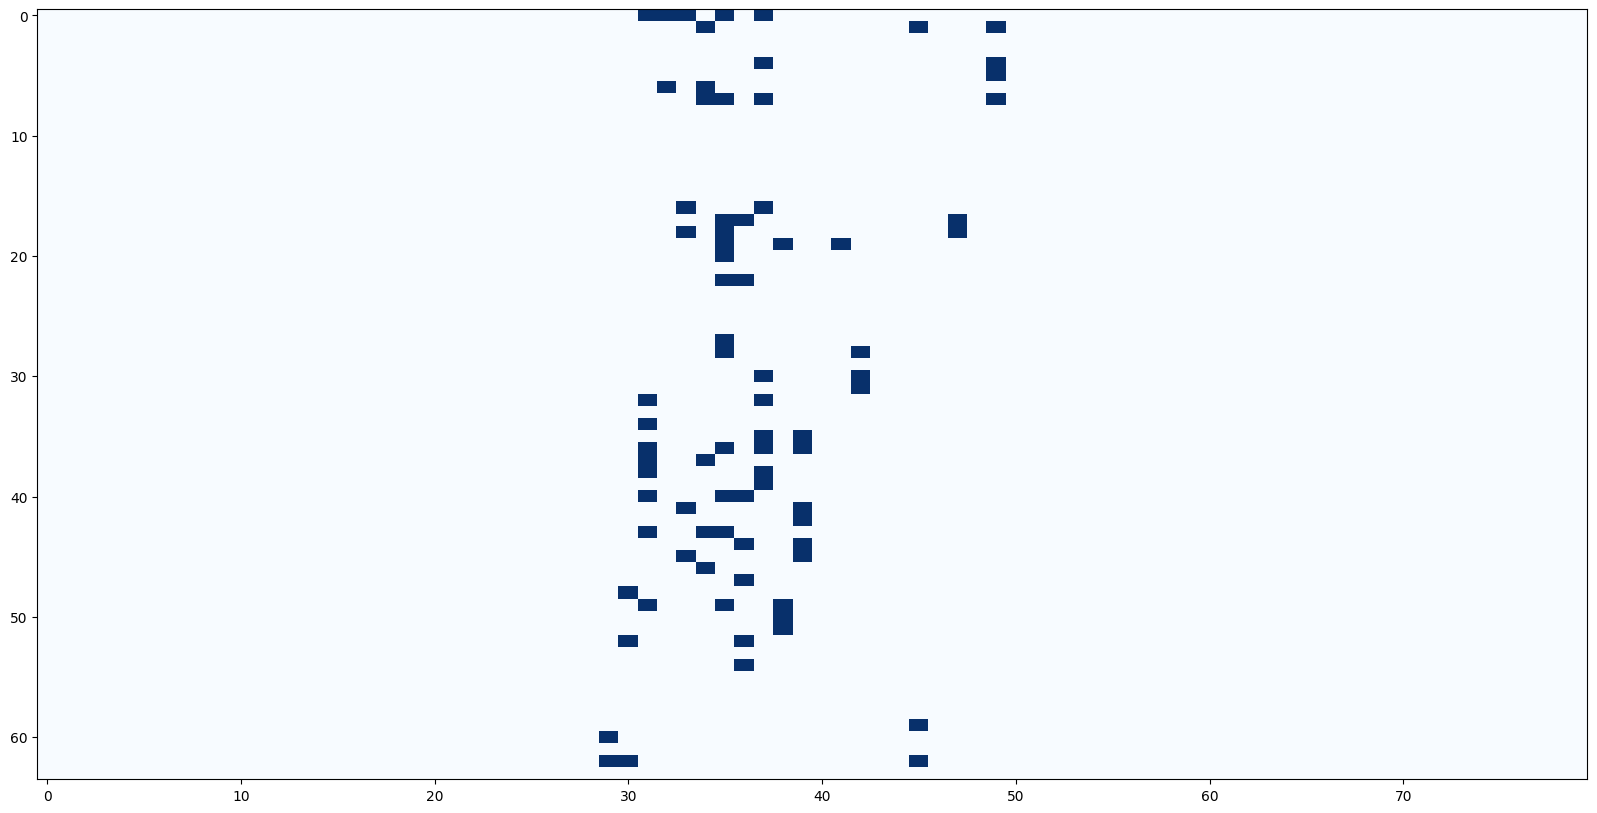

In [14]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[50:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

heads_selected = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
heads_selected = [
    (layer_idx, head_idx) for layer_idx, head_idx in heads_selected if layer_idx < 50
]
print(len(heads_selected))

HEADS = heads_selected

(35, 19) in HEADS, (35, 19) in heads_selected

In [82]:
from src.selection.functional import verify_head_patterns
from src.functional import generate_with_patch

# prompt = """You have a red card. I have a blue card.
# Q: Who has the red card?
# A:"""

# chat = [
#     {"role": "user", "content": "You have a red card. I have a blue card.\nWho has the red card?"},
#     {"role": "assistant", "content": "Answer:"},
# ]

# prompt = mt.tokenizer.apply_chat_template(chat, tokenize=False)
# print(prompt)

prompt = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

You have a red card. I have a blue card.
Who has the red card?
<|eot_id|><|start_header_id|>assistant<|end_header_id|>
Answer:"""

print("====")

# prompt = """Adam is shorter than Bob. Bob is taller than Charlie
# Q: Who is the tallest?
# A:"""

gen = generate_with_patch(
    inputs=prompt,
    mt=mt,
    n_gen_per_prompt=1,
    remove_prefix=True
)[0]

print(gen)

====
 I do. You have the blue card.


In [87]:
test_attn = verify_head_patterns(
    prompt = prompt,
    options = ["You", "I"],
    mt=mt,
    pivot="You",
    heads=heads_selected,
    # heads = [(35, 19)]
    start_from=2,
    query_index=-5
)

0 patches to ablate possible answer information from options
2025-08-21 17:34:22 src.selection.functional DEBUG    Predictions: ['" I"[358] (p=1.000, logit=38.000)', '" You"[1472] (p=0.000, logit=29.625)', '" **"[3146] (p=0.000, logit=27.250)', '" Me"[2206] (p=0.000, logit=27.000)', '" ""[330] (p=0.000, logit=25.125)']
2025-08-21 17:34:22 src.selection.functional INFO     Combined attention matrix for all heads


In [49]:
from src.attention import get_attention_matrices
from src.selection.functional import (
    verify_head_patterns,
    get_patches_to_verify_independent_enrichment,
)

attn_pattern = verify_head_patterns(
    prompt=sample.prompt(option_style="single_line"),
    options=sample.options,
    pivot=sample.subj,
    mt=mt,
    heads=HEADS,
)

0 patches to ablate possible answer information from options
2025-08-21 17:17:57 src.selection.functional DEBUG    Predictions: ['" Orange"[22725] (p=0.820, logit=22.375)', '" An"[1556] (p=0.067, logit=19.875)', '" The"[578] (p=0.060, logit=19.750)', '" Among"[22395] (p=0.022, logit=18.750)', '" orange"[19087] (p=0.006, logit=17.375)']
2025-08-21 17:17:57 src.selection.functional INFO     Combined attention matrix for all heads


In [50]:
import copy
import random
from src.selection.utils import KeyedSet, get_first_token_id, verify_correct_option
from src.selection.data import SelectionSample
from src.functional import predict_next_token
from src.tokens import prepare_input

######################################################################
N_DISTRACTORS = 5
WINDOW_SPEC = {
    mt.layer_name_format: 1,
    mt.mlp_module_name_format: 9,
    mt.attn_module_name_format: 9,
}
module_name_format = mt.layer_name_format
# module_name_format = mt.mlp_module_name_format
# module_name_format = mt.attn_module_name_format

######################################################################


@torch.inference_mode()
def get_counterfactual_samples_within_task(
    task: SelectOneTask | SelectOrderTask = select_task,
    patch_category: str | None = None,
    clean_category: str | None = None,
    shuffle_clean_options: bool = False,
    prompt_template_idx=2,
    option_style="numbered",
    filter_by_lm_prediction: bool = True,
    distinct_options: bool = False,
    n_distractors: int = N_DISTRACTORS,
):
    categories = list(task.category_wise_examples.keys())
    if patch_category is None:
        patch_category = random.choice(categories)

    patch_subj, patch_obj = random.sample(
        task.category_wise_examples[patch_category], 2
    )
    logger.info(
        f"Patch category: {patch_category}, subject: {patch_subj}, object: {patch_obj}"
    )

    if clean_category is None:
        clean_category = random.choice(list(set(categories) - {patch_category}))

    clean_options = task.category_wise_examples[clean_category]
    random.shuffle(clean_options)

    clean_subj, clean_obj = random.sample(
        (
            KeyedSet(clean_options, mt.tokenizer) - KeyedSet([patch_obj], mt.tokenizer)
        ).values,
        2,
    )
    logger.info(
        f"Clean category: {clean_category}, subject: {clean_subj}, object: {clean_obj}"
    )

    if distinct_options is False:
        patch_type_obj = patch_obj
        clean_type_obj = clean_obj
    else:
        patch_type_obj = random.choice(
            (
                KeyedSet(task.category_wise_examples[patch_category], mt.tokenizer)
                - KeyedSet([patch_obj], mt.tokenizer)
            ).values
        )
        clean_type_obj = random.choice(
            (
                KeyedSet(task.category_wise_examples[clean_category], mt.tokenizer)
                - KeyedSet([clean_obj], mt.tokenizer)
            ).values
        )

    patch_must_have_options = [patch_obj, clean_type_obj]
    clean_must_have_options = [clean_obj, patch_type_obj]

    logger.info(f"{patch_must_have_options=}")
    logger.info(f"{clean_must_have_options=}")
    logger.info(f"{clean_type_obj=}")
    logger.info(f"{patch_type_obj=}")

    patch_distractors = []
    other_categories = random.sample(
        list(set(categories) - {patch_category, clean_category}),
        k=n_distractors - (len(patch_must_have_options)) + 1,
    )

    for other_category in other_categories:
        other_examples = task.category_wise_examples[other_category]
        random.shuffle(other_examples)
        other_examples = KeyedSet(other_examples, mt.tokenizer)
        patch_distractors.append(
            random.choice(
                (
                    other_examples
                    - KeyedSet(
                        patch_must_have_options + patch_distractors,
                        tokenizer=mt.tokenizer,
                    )
                ).values
            )
        )

    patch_options = patch_must_have_options + patch_distractors
    random.shuffle(patch_options)
    patch_obj_idx = patch_options.index(patch_obj)
    logger.info(f"{patch_obj_idx=} | {patch_options}")

    if distinct_options is not True:
        clean_options = copy.deepcopy(patch_options)
        if shuffle_clean_options:
            # Useful for the pointer experiments
            while (
                clean_options.index(clean_obj) == patch_obj_idx
                or clean_options.index(patch_type_obj) == patch_obj_idx
            ):
                random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    else:
        other_categories = random.sample(
            list(set(categories) - {patch_category, clean_category}),
            k=n_distractors - (len(clean_must_have_options)) + 1,
        )
        clean_distractors = []
        for other_category in other_categories:
            other_examples = task.category_wise_examples[other_category]
            random.shuffle(other_examples)
            other_examples = KeyedSet(other_examples, mt.tokenizer)
            clean_distractors.append(
                random.choice(
                    (
                        other_examples
                        - KeyedSet(
                            clean_must_have_options + clean_distractors,
                            tokenizer=mt.tokenizer,
                        )
                    ).values
                )
            )
        clean_options = clean_must_have_options + clean_distractors
        random.shuffle(clean_options)
        while clean_options.index(clean_obj) == patch_obj_idx:
            random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    logger.info(f"{clean_obj_idx=} | {clean_options}")

    kwargs = dict(
        prompt_template=task.prompt_templates[prompt_template_idx],
        default_option_style=option_style,
    )
    print(f"{type(task)=}")
    if isinstance(task, SelectOrderTask):
        patch_metadata = {
            "track_type_obj_idx": clean_obj_idx,
            "track_type_obj": patch_options[clean_obj_idx],
            "track_type_obj_token_id": get_first_token_id(
                patch_options[clean_obj_idx], mt.tokenizer, prefix=" "
            ),
        }
        clean_metadata = {
            "track_type_obj_idx": patch_obj_idx,
            "track_type_obj": clean_options[patch_obj_idx],
            "track_type_obj_token_id": get_first_token_id(
                clean_options[patch_obj_idx], mt.tokenizer, prefix=" "
            ),
        }
    elif isinstance(task, SelectOneTask):
        patch_metadata = {
            "track_category": clean_category,
            "track_type_obj": clean_type_obj,
            "track_type_obj_idx": patch_options.index(clean_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                clean_type_obj, mt.tokenizer, prefix=" "
            ),
        }
        clean_metadata = {
            "track_category": patch_category,
            "track_type_obj": patch_type_obj,
            "track_type_obj_idx": clean_options.index(patch_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                patch_type_obj, mt.tokenizer, prefix=" "
            ),
        }
    else:
        raise NotImplementedError(f"Unsupported task type: {type(task)}")

    patch_sample = SelectionSample(
        subj=patch_subj,
        obj=patch_obj,
        answer=patch_obj,
        obj_idx=patch_obj_idx,
        ans_token_id=get_first_token_id(patch_obj, mt.tokenizer, prefix=" "),
        options=patch_options,
        category=patch_category,
        metadata=patch_metadata,
        **kwargs,
    )
    clean_sample = SelectionSample(
        subj=clean_subj,
        obj=clean_obj,
        answer=clean_obj,
        obj_idx=clean_obj_idx,
        ans_token_id=get_first_token_id(clean_obj, mt.tokenizer, prefix=" "),
        options=clean_options,
        category=clean_category,
        metadata=clean_metadata,
        **kwargs,
    )

    if filter_by_lm_prediction:
        test_samples = [patch_sample, clean_sample]
        if distinct_options is True:
            clean_sample_2 = copy.deepcopy(patch_sample)
            clean_sample_2.options = clean_options
            clean_sample_2.obj = clean_sample.metadata["track_type_obj"]
            clean_sample_2.obj_idx = clean_sample.metadata["track_type_obj_idx"]
            clean_sample_2.ans_token_id = clean_sample.metadata[
                "track_type_obj_token_id"
            ]
            test_samples.append(clean_sample_2)

        for sample in test_samples:
            tokenized = prepare_input(tokenizer=mt, prompts=sample.prompt())
            is_correct, predictions, track_options = verify_correct_option(
                mt=mt, target=sample.obj, options=sample.options, input=tokenized
            )
            sample.metadata["tokenized"] = tokenized.data
            logger.info(sample.prompt())
            logger.info(
                f"{sample.subj} | {sample.category} -> {sample.obj} | pred={[str(p) for p in predictions]}"
            )
            if not is_correct:
                logger.error(
                    f'Prediction mismatch: {track_options[list(track_options.keys())[0]]}["{mt.tokenizer.decode(list(track_options.keys())[0])}"] != {sample.ans_token_id}["{mt.tokenizer.decode(sample.ans_token_id)}"]'
                )
                return get_counterfactual_samples_within_task(
                    task=task,
                    patch_category=patch_category,
                    clean_category=clean_category,
                    shuffle_clean_options=shuffle_clean_options,
                    prompt_template_idx=prompt_template_idx,
                    option_style=option_style,
                    filter_by_lm_prediction=filter_by_lm_prediction,
                    distinct_options=distinct_options,
                    n_distractors=n_distractors,
                )
            sample.prediction = predictions

    return patch_sample, clean_sample

In [51]:
type(select_task)

src.selection.data.SelectOneTask

In [54]:
patch_sample, clean_sample = get_counterfactual_samples_within_task(
    # patch_category="politician",
    # clean_category="actor",
    task=select_task,
    patch_category="fruit",
    clean_category="vehicle",
    filter_by_lm_prediction=True,
    prompt_template_idx=prompt_template_idx,
    option_style=OPTION_STYLE,
    # distinct_options=True,
    distinct_options=False,
    n_distractors=N_DISTRACTORS,
)

# patch_sample.default_option_style = "single_line"
# clean_sample.default_option_style = "numbered"

clean_sample.metadata

2025-08-21 17:18:18 __main__ INFO     Patch category: fruit, subject: Plum, object: Banana


2025-08-21 17:18:18 __main__ INFO     Clean category: vehicle, subject: Car, object: Bus
2025-08-21 17:18:18 __main__ INFO     patch_must_have_options=['Banana', 'Bus']
2025-08-21 17:18:18 __main__ INFO     clean_must_have_options=['Bus', 'Banana']
2025-08-21 17:18:18 __main__ INFO     clean_type_obj='Bus'
2025-08-21 17:18:18 __main__ INFO     patch_type_obj='Banana'
2025-08-21 17:18:18 __main__ INFO     patch_obj_idx=1 | ['Basketball', 'Banana', 'Bus', 'Coat', 'Mixer', 'Ring']
2025-08-21 17:18:18 __main__ INFO     clean_obj_idx=2 | ['Basketball', 'Banana', 'Bus', 'Coat', 'Mixer', 'Ring']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-08-21 17:18:18 __main__ INFO     Options: Basketball, Banana, Bus, Coat, Mixer, Ring.
Which among these objects mentioned above is a fruit?
Answer:
2025-08-21 17:18:18 __main__ INFO     Plum | fruit -> Banana | pred=['" Banana"[76924] (p=0.742, logit=22.000)', '" The"[578] (p=0.129, logit=20.250)', '" Among"[22395] (p=0.054, logit=19.375)', '"

{'track_category': 'fruit',
 'track_type_obj': 'Banana',
 'track_type_obj_idx': 1,
 'track_type_obj_token_id': 76924,
 'tokenized': {'input_ids': tensor([[128000,   3883,     25,  47589,     11,  76924,     11,  19111,     11,
            68867,     11,  72392,     11,  22249,    627,  23956,   4315,   1521,
             6302,   9932,   3485,    374,    264,   7458,   5380,  16533,     25]],
         device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1]], device='cuda:0')}}

In [55]:
from src.functional import generate_with_patch

# patch_sample.options[patch_sample.obj_idx] = "Screw"
# patch_sample.options[patch_sample.obj_idx] = patch_sample.obj
for sample in [patch_sample, clean_sample]:
# for sample in [order_sample_1, order_sample_2]:
    print(sample.prompt(), ">>", sample.obj)
    attn_pattern = verify_head_patterns(
        prompt=sample.prompt(),
        options=sample.options,
        pivot=sample.subj,
        mt=mt,
        heads=HEADS,
        generate_full_answer=True,
        query_index=-1
    )

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Options: Basketball, Banana, Bus, Coat, Mixer, Ring.
Which among these objects mentioned above is a fruit?
Answer: >> Banana
0 patches to ablate possible answer information from options
2025-08-21 17:18:23 src.selection.functional DEBUG    Generated full answer: " Banana
Explanation: Banana is a fruit. It is a type of elongated, edible fruit that grows on banana plants. The other options are not"
2025-08-21 17:18:23 src.selection.functional DEBUG    Predictions: ['" Banana"[76924] (p=0.742, logit=22.000)', '" The"[578] (p=0.129, logit=20.250)', '" Among"[22395] (p=0.054, logit=19.375)', '" A"[362] (p=0.033, logit=18.875)', '" B"[426] (p=0.012, logit=17.875)']
2025-08-21 17:18:23 src.selection.functional INFO     Combined attention matrix for all heads


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Options: Basketball, Banana, Bus, Coat, Mixer, Ring.
Which among these objects mentioned above is a vehicle?
Answer: >> Bus
0 patches to ablate possible answer information from options
2025-08-21 17:18:28 src.selection.functional DEBUG    Generated full answer: " Bus.
Explanation: A bus is a large vehicle, typically designed to carry numerous passengers along a fixed route. It is a mode of public transportation."
2025-08-21 17:18:28 src.selection.functional DEBUG    Predictions: ['" Bus"[19111] (p=0.672, logit=22.125)', '" The"[578] (p=0.133, logit=20.500)', '" Among"[22395] (p=0.081, logit=20.000)', '" A"[362] (p=0.071, logit=19.875)', '" It"[1102] (p=0.005, logit=17.125)']
2025-08-21 17:18:28 src.selection.functional INFO     Combined attention matrix for all heads


In [56]:
clean_sample.metadata

{'track_category': 'fruit',
 'track_type_obj': 'Banana',
 'track_type_obj_idx': 1,
 'track_type_obj_token_id': 76924,
 'tokenized': {'input_ids': tensor([[128000,   3883,     25,  47589,     11,  76924,     11,  19111,     11,
            68867,     11,  72392,     11,  22249,    627,  23956,   4315,   1521,
             6302,   9932,   3485,    374,    264,   7458,   5380,  16533,     25]],
         device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1]], device='cuda:0')}}

In [57]:
clean_tokenized = prepare_input(prompts = clean_sample.prompt(), tokenizer=mt.tokenizer)
patch_tokenized = prepare_input(prompts = patch_sample.prompt(), tokenizer=mt.tokenizer)
clean_tokenized.input_ids.shape, patch_tokenized.input_ids.shape

(torch.Size([1, 27]), torch.Size([1, 27]))

## Optimization to select heads to patch

In [47]:
from src.functional import free_gpu_cache
free_gpu_cache()

#################################################################################
train_limit = 512
# prompt_template_idx = 1
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

train_set = []
while len(train_set) < train_limit:
    patch, clean = get_counterfactual_samples_within_task(
        task=select_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        option_style=OPTION_STYLE,
        distinct_options=True,
        n_distractors=N_DISTRACTORS,
    )
    train_set.append((clean, patch))

2025-08-19 22:21:34 __main__ INFO     Patch category: clothing, subject: Dress, object: Shirt
2025-08-19 22:21:34 __main__ INFO     Clean category: animal, subject: Bear, object: Dog
2025-08-19 22:21:34 __main__ INFO     patch_must_have_options=['Shirt', 'Eagle']
2025-08-19 22:21:34 __main__ INFO     clean_must_have_options=['Dog', 'Jeans']
2025-08-19 22:21:34 __main__ INFO     clean_type_obj='Eagle'
2025-08-19 22:21:34 __main__ INFO     patch_type_obj='Jeans'
2025-08-19 22:21:34 __main__ INFO     patch_obj_idx=1 | ['Boat', 'Shirt', 'Plum', 'Maple', 'Folder', 'Eagle']
2025-08-19 22:21:34 __main__ INFO     clean_obj_idx=3 | ['Football', 'Watch', 'Jeans', 'Dog', 'Strawberry', 'Notebook']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-08-19 22:21:34 __main__ INFO     Options: Boat, Shirt, Plum, Maple, Folder, Eagle.
Which among these objects mentioned above is a clothing?
Answer:
2025-08-19 22:21:34 __main__ INFO     Dress | clothing -> Shirt | pred=['" Shirt"[55807] (p=0.719,

In [49]:
mt._model.zero_grad()
free_gpu_cache()
print(len(train_set))
print(len(heads_selected))

512
66


In [ ]:
from src.selection.optimization import get_optimal_head_mask
import numpy as np

free_gpu_cache()
optimal_mask, losses = get_optimal_head_mask(
    mt=mt,
    train_set=train_set,
    learning_rate=1e-2,
    n_epochs=20,
    lamb=2e-2,
    batch_size=16,
    query_indices=[-3, -2, -1],
    black_list_heads=heads_selected
)

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    # "selection/optimized_heads",
    "selection/optimized_backup_heads",
    # "selection/optimized_single_tok",
    # "selection/optimized_same_collection_single_tok",
    mt.name.split("/")[-1],
    f"{TASK_CLS.task_name}.npz"
)

os.makedirs(os.path.dirname(optimized_path), exist_ok=True)

np.savez_compressed(
    optimized_path,
    **dict(
        optimal_mask=optimal_mask.to(torch.float32).numpy(),
        losses=np.array(losses, dtype=np.float32),
    ),
    allow_pickle=True,
)

2025-08-19 23:54:24 src.selection.optimization DEBUG    Training with hparams: {'learning_rate': 0.01, 'n_epochs': 20, 'lamb': 0.02, 'batch_size': 16}
2025-08-19 23:54:24 src.selection.optimization INFO     Caching q projections from patch samples...
2025-08-19 23:54:34 src.selection.optimization INFO     Caching completed > 1/32 batches.
2025-08-19 23:54:44 src.selection.optimization INFO     Caching completed > 2/32 batches.
2025-08-19 23:54:54 src.selection.optimization INFO     Caching completed > 3/32 batches.
2025-08-19 23:55:04 src.selection.optimization INFO     Caching completed > 4/32 batches.
2025-08-19 23:55:15 src.selection.optimization INFO     Caching completed > 5/32 batches.
2025-08-19 23:55:26 src.selection.optimization INFO     Caching completed > 6/32 batches.
2025-08-19 23:55:36 src.selection.optimization INFO     Caching completed > 7/32 batches.
2025-08-19 23:55:46 src.selection.optimization INFO     Caching completed > 8/32 batches.
2025-08-19 23:55:56 src.selec

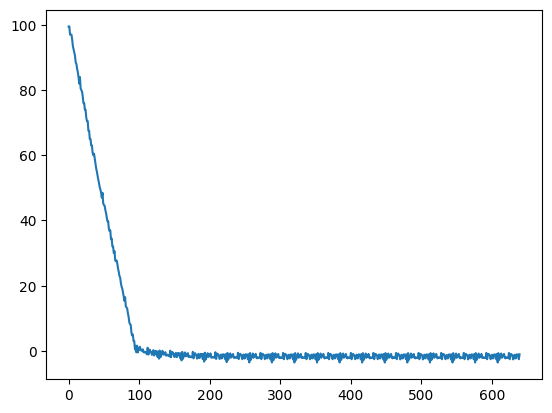

In [105]:
from matplotlib import pyplot as plt

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    # "selection/optimized_heads",
    "selection/optimized_backup_heads",
    # "selection/optimized_single_tok",
    # "selection/optimized_same_collection_single_tok",
    mt.name.split("/")[-1],
    f"{TASK_CLS.task_name}.npz"
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])

28


(False, False)

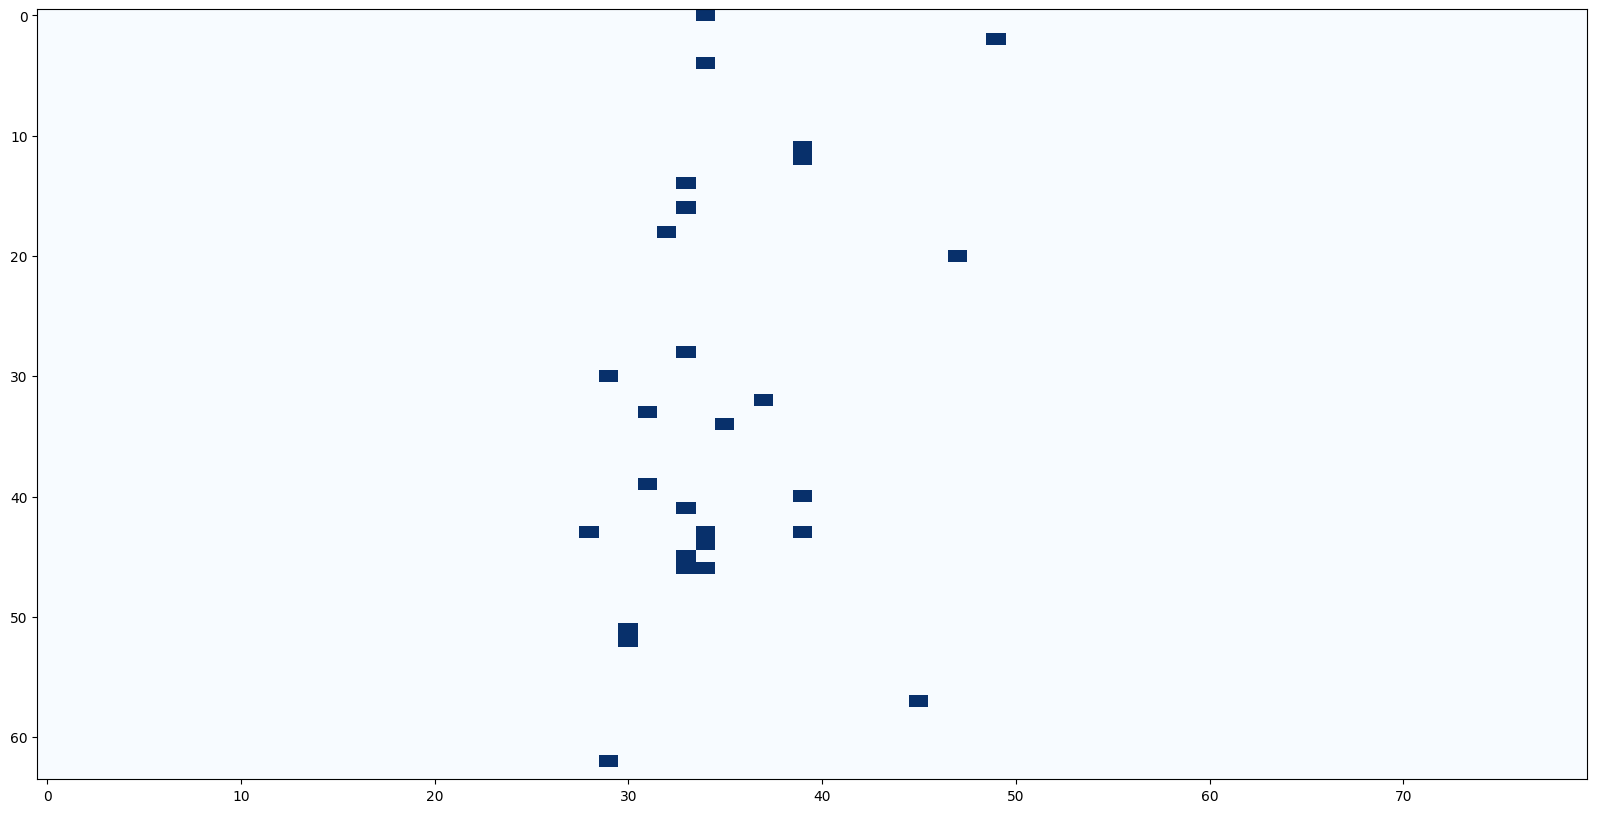

In [130]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[50:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

backup_heads = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).to(dtype=torch.int).tolist()
backup_heads = [
    (layer_idx, head_idx) for layer_idx, head_idx in backup_heads
]
print(len(backup_heads))

HEADS = backup_heads

(35, 19) in HEADS, (35, 19) in backup_heads

In [107]:
len(heads_selected), len(backup_heads)

(66, 39)

## Validation of the patching effect

In [59]:
from src.functional import free_gpu_cache
free_gpu_cache()
validation_set = []
validation_limit = 256

while len(validation_set) < validation_limit:
    patch, clean = get_counterfactual_samples_within_task(
        task=select_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        option_style=OPTION_STYLE,
        n_distractors=N_DISTRACTORS,
        # distinct_options=True,
        distinct_options=False,
        shuffle_clean_options=True
    )
    validation_set.append((clean, patch))

2025-08-21 17:18:59 __main__ INFO     Patch category: vehicle, subject: Motorcycle, object: Bike
2025-08-21 17:18:59 __main__ INFO     Clean category: tree, subject: Oak, object: Ash
2025-08-21 17:18:59 __main__ INFO     patch_must_have_options=['Bike', 'Ash']
2025-08-21 17:18:59 __main__ INFO     clean_must_have_options=['Ash', 'Bike']
2025-08-21 17:18:59 __main__ INFO     clean_type_obj='Ash'
2025-08-21 17:18:59 __main__ INFO     patch_type_obj='Bike'
2025-08-21 17:18:59 __main__ INFO     patch_obj_idx=2 | ['Guitar', 'Baseball', 'Bike', 'Shower', 'Speaker', 'Ash']
2025-08-21 17:18:59 __main__ INFO     clean_obj_idx=0 | ['Ash', 'Shower', 'Baseball', 'Guitar', 'Bike', 'Speaker']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-08-21 17:18:59 __main__ INFO     Options: Guitar, Baseball, Bike, Shower, Speaker, Ash.
Which among these objects mentioned above is a vehicle?
Answer:
2025-08-21 17:18:59 __main__ INFO     Motorcycle | vehicle -> Bike | pred=['" Bike"[38930] (p=0.801, 

In [30]:
len(validation_set)

256

In [31]:
mt.reset_forward()
# set_attn_implementation(mt, "eager")

In [32]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair


clean, patch = copy.deepcopy(validation_set[18])
# clean.default_option_style="numbered"
# patch.default_option_style="numbered"
# clean, patch = train_set[18]

# clean, patch = copy.deepcopy(clean_sample), copy.deepcopy(patch_sample)
# clean.prompt_template = "<_options_>\nFind the <_category_> in the list.\nAnswer:"
# patch.prompt_template = "<_options_>\nFind the <_category_> in the list.\nAnswer:"

# clean, patch = order_sample_2, order_sample_1
# patch, clean = order_sample_1, order_sample_2

# failed_case = copy.deepcopy(failed_cases[21])
# failed_case = copy.deepcopy(failed_pos_track["patch_obj_idx"][2])
# clean = failed_case["clean_sample"]
# patch = failed_case["patch_sample"]

print(clean.prompt(), ">>", clean.obj)
print(patch.prompt(), ">>", patch.obj)

validation_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    # heads=HEADS,
    heads=heads_selected,
    # heads=backup_heads,
    # heads=heads_selected + backup_heads,
    # heads = overlapping_heads,
    # heads=[(35, 19)],
    query_indices={-3: -3, -2: -2, -1: -1},
    verify_head_behavior_on=-1,
    # ablate_possible_ans_info_from_options=True,
    # amplification_scale=2.0
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": validation_result["clean_track"][clean_obj][0],
    "clean_logit": validation_result["clean_track"][clean_obj][1].logit,
    "target_rank": validation_result["clean_track"][target_obj][0],
    "target_logit": validation_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": validation_result["int_track"][clean_obj][0],
    "clean_logit": validation_result["int_track"][clean_obj][1].logit,
    "target_rank": validation_result["int_track"][target_obj][0],
    "target_logit": validation_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = (
    after_intervention["target_rank"] - before_intervention["target_rank"]
)
logger.info(
    f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} "
)
logger.info(
    f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} "
)

clean_logit_delta = (
    after_intervention["clean_logit"] - before_intervention["clean_logit"]
)
target_logit_delta = (
    after_intervention["target_logit"] - before_intervention["target_logit"]
)
logger.info(
    f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} "
)
logger.info(
    f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} "
)

Options: Oven, Jeans, Willow, Paper, Jasmine, Piano.
Which among these objects mentioned above is a flower?
Answer: >> Jasmine
Options: Piano, Jasmine, Paper, Jeans, Oven, Willow.
Which among these objects mentioned above is a clothing?
Answer: >> Jeans
2025-08-21 14:48:35 src.selection.optimization INFO     Verifying head behavior...
2025-08-21 14:48:35 src.selection.optimization INFO     Clean Sample >> Ans: Jasmine


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-21 14:48:39 src.selection.functional DEBUG    Generated full answer: " Jasmine is a flower. It is a type of flowering plant in the olive family. It is native to tropical and warm temperate regions of the world"
2025-08-21 14:48:39 src.selection.functional DEBUG    Predictions: ['" Jasmine"[82452] (p=0.824, logit=21.375)', '" Among"[22395] (p=0.060, logit=18.750)', '" The"[578] (p=0.053, logit=18.625)', '" jasmine"[66909] (p=0.012, logit=17.125)', '" Option"[7104] (p=0.004, logit=16.125)']
2025-08-21 14:48:39 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-21 14:48:39 src.selection.optimization INFO     Patch Sample >> Ans: Jeans


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-21 14:48:43 src.selection.functional DEBUG    Generated full answer: " Jeans. Jeans is a type of clothing. The other options are not clothing. Piano is a musical instrument, Jasmine is a flower, Paper is a"
2025-08-21 14:48:43 src.selection.functional DEBUG    Predictions: ['" Jeans"[82507] (p=0.883, logit=22.375)', '" The"[578] (p=0.044, logit=19.375)', '" Among"[22395] (p=0.039, logit=19.250)', '" JE"[71430] (p=0.005, logit=17.250)', '" Option"[7104] (p=0.004, logit=16.875)']
2025-08-21 14:48:43 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-21 14:48:43 src.selection.optimization INFO     Caching the query states for the 80 heads
2025-08-21 14:48:44 src.selection.optimization INFO     patch_prediction=['" Jeans"[82507] (p=0.883, logit=22.375)', '" The"[578] (p=0.044, logit=19.375)', '" Among"[22395] (p=0.039, logit=19.250)', '" JE"[71430] (p=0.005, logit=17.250)', '" Option"[7104] (p=0.004, logit=16.875)']
2025-08-21 14:48:44 src.selection.optimization INFO     clean run
2025-08-21 14:48:44 src.selection.optimization INFO     clean_prediction=['" Jasmine"[82452] (p=0.824, logit=21.375)', '" Among"[22395] (p=0.060, logit=18.750)', '" The"[578] (p=0.053, logit=18.625)', '" jasmine"[66909] (p=0.012, logit=17.125)', '" Option"[7104] (p=0.004, logit=16.125)']
2025-08-21 14:48:44 src.selection.optimization INFO     clean_track=OrderedDict([(82452, (1, PredictedToken(token=' Jasmine', prob=0.82421875, logit=21.375, token_id=82452, metadata=None))), (65449, (21, PredictedToken(token=' Willow', prob=0.00080108642578125, log

2025-08-21 14:48:44 src.selection.optimization INFO     int_prediction=['" Jeans"[82507] (p=0.727, logit=21.000)', '" The"[578] (p=0.087, logit=18.875)', '" Oven"[87213] (p=0.060, logit=18.500)', '" Among"[22395] (p=0.053, logit=18.375)', '" Option"[7104] (p=0.008, logit=16.500)']
2025-08-21 14:48:44 src.selection.optimization INFO     int_track=OrderedDict([(82507, (1, PredictedToken(token=' Jeans', prob=0.7265625, logit=21.0, token_id=82507, metadata=None))), (87213, (3, PredictedToken(token=' Oven', prob=0.0595703125, logit=18.5, token_id=87213, metadata=None))), (65449, (129, PredictedToken(token=' Willow', prob=2.574920654296875e-05, logit=10.75, token_id=65449, metadata=None))), (18343, (312, PredictedToken(token=' Paper', prob=4.202127456665039e-06, logit=8.9375, token_id=18343, metadata=None))), (56491, (369, PredictedToken(token=' Piano', prob=3.069639205932617e-06, logit=8.625, token_id=56491, metadata=None))), (82452, (1336, PredictedToken(token=' Jasmine', prob=5.5134296417

In [33]:
from tqdm.auto import tqdm

validation_results = []
for clean_sample, patch_sample in tqdm(validation_set):
    # clean_sample = copy.deepcopy(clean_sample)
    # clean_sample.options = patch_sample.options
    result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=heads_selected,
        # heads=backup_heads,
        # heads=heads_selected + backup_heads,
        # heads = overlapping_heads,
        query_indices={-3: -3, -2: -2, -1: -1},
        verify_head_behavior_on=None,
        # amplification_scale=1.5
    )
    validation_results.append(result)
    print("=" * 80)

  0%|          | 0/256 [00:00<?, ?it/s]

2025-08-21 14:48:50 src.selection.optimization INFO     Caching the query states for the 80 heads
2025-08-21 14:48:51 src.selection.optimization INFO     patch_prediction=['" Television"[41445] (p=0.824, logit=21.625)', '" Oven"[87213] (p=0.068, logit=19.125)', '" The"[578] (p=0.028, logit=18.250)', '" Among"[22395] (p=0.025, logit=18.125)', '" Option"[7104] (p=0.006, logit=16.750)']
2025-08-21 14:48:51 src.selection.optimization INFO     clean run
2025-08-21 14:48:51 src.selection.optimization INFO     clean_prediction=['" Oven"[87213] (p=0.793, logit=21.375)', '" Among"[22395] (p=0.058, logit=18.750)', '" The"[578] (p=0.058, logit=18.750)', '" An"[1556] (p=0.035, logit=18.250)', '" Option"[7104] (p=0.008, logit=16.750)']
2025-08-21 14:48:51 src.selection.optimization INFO     clean_track=OrderedDict([(87213, (1, PredictedToken(token=' Oven', prob=0.79296875, logit=21.375, token_id=87213, metadata=None))), (41445, (17, PredictedToken(token=' Television', prob=0.0009918212890625, logit

In [55]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [56]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

clean_rank_delta: 211.6445 ± 450.1842
target_rank_delta: -259.3086 ± 543.5372
clean_rank_after_intervention: 212.6484 ± 450.1823
target_rank_after_intervention: 2.3750 ± 5.4206


In [57]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

clean_logit_delta: -8.9279 ± 3.6970
target_logit_delta: 8.5413 ± 3.7036
clean_logit_after_intervention: 12.4916 ± 3.4656
target_logit_after_intervention: 20.0574 ± 1.7830


In [58]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

0.76953125

In [59]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)
print(f"{len(failed_cases)}")

Counterfactual patching accuracy: 0.7812 (200/256)
56


In [39]:
for failed_case in failed_cases[:20]:
    clean_sample = failed_case["clean_sample"]
    patch_sample = failed_case["patch_sample"]
    int_track = failed_case["int_track"]
    clean_track = failed_case["clean_track"]

    print("Clean Sample:")
    print(clean_sample.prompt(), ">>", clean_sample.obj)

    print("-" * 100)
    print(
        "Track: ",
        clean_sample.metadata["track_type_obj"], " | Token"
        f"\"{mt.tokenizer.decode(clean_sample.metadata['track_type_obj_token_id'])}\"",
    )
    print("Clean:", clean_sample.obj, f"(Token: {mt.tokenizer.decode(clean_sample.ans_token_id)})")
    print("-" * 100)

    clean_track = [pred for tok_id, (rank, pred) in clean_track.items()]
    print(f"Clean Track: {json.dumps([str(pred) for pred in clean_track], indent=4)}")

    int_track = [pred for tok_id, (rank, pred) in int_track.items()]
    print(
        f"Intervened Track: {json.dumps([str(pred) for pred in int_track], indent=4)}"
    )
    print("=" * 100)

Clean Sample:
Options: Dolphin, Stadium, Ring, Helmet, Television, Potato.
Which among these objects mentioned above is a jewelry?
Answer: >> Ring
----------------------------------------------------------------------------------------------------
Track:  Potato  | Token" Potato"
Clean: Ring (Token:  Ring)
----------------------------------------------------------------------------------------------------
Clean Track: [
    "\" Ring\"[22249] (p=0.844, logit=21.375)",
    "\" Dolphin\"[96096] (p=0.000, logit=13.938)",
    "\" Helmet\"[67629] (p=0.000, logit=13.625)",
    "\" Stadium\"[23462] (p=0.000, logit=10.562)",
    "\" Potato\"[78703] (p=0.000, logit=9.875)",
    "\" Television\"[41445] (p=0.000, logit=9.438)"
]
Intervened Track: [
    "\" Dolphin\"[96096] (p=0.344, logit=18.250)",
    "\" Potato\"[78703] (p=0.077, logit=16.750)",
    "\" Ring\"[22249] (p=0.026, logit=15.688)",
    "\" Television\"[41445] (p=0.001, logit=12.750)",
    "\" Stadium\"[23462] (p=0.000, logit=9.688)",


In [60]:
#! find the positions after the patched intervention.
# Is it looking at the first one, or the position of the 
# previous answer?

failed_pos_track = {
    "clean_obj_idx": [],
    "patch_obj_idx": [],
    "first_obj_idx": [],
    "other": []
}

for failed_case in failed_cases[:20]:
    clean_sample = failed_case["clean_sample"]
    patch_sample = failed_case["patch_sample"]
    int_track = failed_case["int_track"]
    clean_track = failed_case["clean_track"]
    clean_obj_idx = clean_sample.obj_idx
    patch_obj_idx = patch_sample.obj_idx

    int_top_tok = list(int_track.keys())[0]
    int_top_obj = int_track[int_top_tok][1].token.strip()
    int_top_idx = clean_sample.options.index(int_top_obj)

    if int_top_idx == clean_obj_idx:
        failed_pos_track["clean_obj_idx"].append(failed_case)
    elif int_top_idx == patch_obj_idx:
        failed_pos_track["patch_obj_idx"].append(failed_case)
    elif int_top_idx == 0:
        failed_pos_track["first_obj_idx"].append(failed_case)
    else:
        failed_pos_track["other"].append(failed_case)


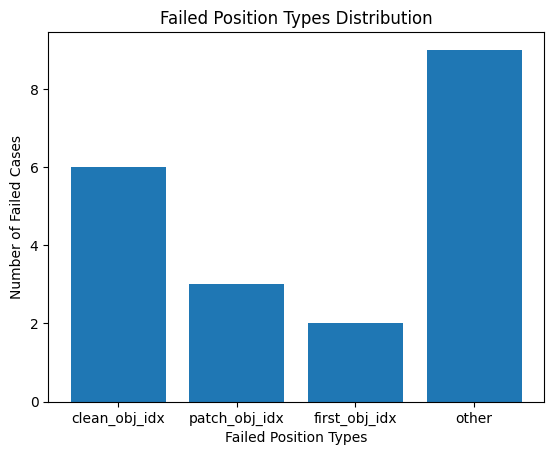

In [61]:
from matplotlib import pyplot as plt
x_vals = failed_pos_track.keys()
y_vals = [len(failed_pos_track[key]) for key in x_vals]
plt.bar(x_vals, y_vals)
plt.xlabel("Failed Position Types")
plt.ylabel("Number of Failed Cases")
plt.title("Failed Position Types Distribution")
plt.show()

In [ ]:
from src.selection.functional import verify_head_patterns
from src.selection.optimization import validate_q_proj_ie_on_sample_pair

# failed_case = copy.deepcopy(failed_pos_track["patch_obj_idx"][2])
failed_case = copy.deepcopy(failed_cases[8])
clean = failed_case["clean_sample"]
patch = failed_case["patch_sample"]

# clean, patch = copy.deepcopy(clean_sample), copy.deepcopy(patch_sample)

clean_tokenized = prepare_input(prompts=clean.prompt(), tokenizer=mt)
patch_tokenized = prepare_input(prompts=patch.prompt(), tokenizer=mt)

validation_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    # heads=HEADS,
    heads=heads_selected,
    # heads=backup_heads,
    # heads=heads_selected + backup_heads,
    # heads = overlapping_heads,
    # heads=[(35, 19)],
    query_indices={-3: -3, -2: -2, -1: -1},
    verify_head_behavior_on=-1,
    # ablate_possible_ans_info_from_options=True,
    amplification_scale=2.0,
    patch_args = {
        "batch_size": 32,
        "task": select_task,
        "prompt_template_idx": prompt_template_idx,
        "option_style": "single_line",
        "distinct_options": False
    }
)

2025-08-21 15:37:28 src.selection.optimization DEBUG    Sampling 32 patch samples...


2025-08-21 15:37:33 src.selection.optimization DEBUG    torch.Size([32, 27])
2025-08-21 15:37:33 src.selection.optimization INFO     Verifying head behavior...
2025-08-21 15:37:33 src.selection.optimization INFO     Clean Sample >> Ans: Sofa


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-21 15:37:37 src.selection.functional DEBUG    Generated full answer: " Sofa. 
Explanation: A sofa is a piece of furniture designed for seating multiple people. It is typically upholstered and has cushions for comfort. Sof"
2025-08-21 15:37:37 src.selection.functional DEBUG    Predictions: ['" Sofa"[61948] (p=0.371, logit=20.375)', '" House"[4783] (p=0.289, logit=20.125)', '" The"[578] (p=0.120, logit=19.250)', '" A"[362] (p=0.057, logit=18.500)', '" Among"[22395] (p=0.050, logit=18.375)']
2025-08-21 15:37:37 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-21 15:37:38 src.selection.optimization INFO     Patch Sample >> Ans: House


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-21 15:37:41 src.selection.functional DEBUG    Generated full answer: " House.
Explanation: A house is a building that serves as a dwelling or residence for one or more families. The other options are not buildings, but"
2025-08-21 15:37:41 src.selection.functional DEBUG    Predictions: ['" House"[4783] (p=0.816, logit=22.625)', '" A"[362] (p=0.059, logit=20.000)', '" The"[578] (p=0.059, logit=20.000)', '" Among"[22395] (p=0.032, logit=19.375)', '" It"[1102] (p=0.008, logit=18.000)']
2025-08-21 15:37:41 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-21 15:37:41 src.selection.optimization INFO     Caching the query states for the 80 heads
2025-08-21 15:37:43 src.selection.optimization INFO     patch_prediction=['" House"[4783] (p=0.816, logit=22.625)', '" The"[578] (p=0.059, logit=20.000)', '" A"[362] (p=0.059, logit=20.000)', '" Among"[22395] (p=0.032, logit=19.375)', '" It"[1102] (p=0.008, logit=18.000)']
2025-08-21 15:37:43 src.selection.optimization INFO     clean run
2025-08-21 15:37:43 src.selection.optimization INFO     clean_prediction=['" Sofa"[61948] (p=0.371, logit=20.375)', '" House"[4783] (p=0.289, logit=20.125)', '" The"[578] (p=0.120, logit=19.250)', '" A"[362] (p=0.057, logit=18.500)', '" Among"[22395] (p=0.050, logit=18.375)']
2025-08-21 15:37:43 src.selection.optimization INFO     clean_track=OrderedDict([(61948, (1, PredictedToken(token=' Sofa', prob=0.37109375, logit=20.375, token_id=61948, metadata=None))), (4783, (2, PredictedToken(token=' House', prob=0.2890625, logit=20.125, token_id=4783, metadata=N

2025-08-21 15:37:44 src.selection.optimization INFO     int_prediction=['" Sofa"[61948] (p=0.367, logit=19.750)', '" House"[4783] (p=0.285, logit=19.500)', '" The"[578] (p=0.135, logit=18.750)', '" A"[362] (p=0.044, logit=17.625)', '" There"[2684] (p=0.027, logit=17.125)']
2025-08-21 15:37:44 src.selection.optimization INFO     int_track=OrderedDict([(61948, (1, PredictedToken(token=' Sofa', prob=0.3671875, logit=19.75, token_id=61948, metadata=None))), (4783, (2, PredictedToken(token=' House', prob=0.28515625, logit=19.5, token_id=4783, metadata=None))), (16488, (15, PredictedToken(token=' Bat', prob=0.0038299560546875, logit=15.1875, token_id=16488, metadata=None))), (59825, (52, PredictedToken(token=' Tie', prob=0.0003795623779296875, logit=12.875, token_id=59825, metadata=None))), (74574, (55, PredictedToken(token=' Violet', prob=0.0003337860107421875, logit=12.75, token_id=74574, metadata=None))), (47759, (128, PredictedToken(token=' Guitar', prob=4.5299530029296875e-05, logit=10.

In [65]:
from tqdm.auto import tqdm

validation_results = []
for clean_sample, patch_sample in tqdm(validation_set):
    # clean_sample = copy.deepcopy(clean_sample)
    # clean_sample.options = patch_sample.options
    result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=heads_selected,
        # heads=backup_heads,
        # heads=heads_selected + backup_heads,
        # heads = overlapping_heads,
        query_indices={-3: -3, -2: -2, -1: -1},
        verify_head_behavior_on=None,
        # amplification_scale=1.5
        patch_args = {
            "batch_size": 16,
            "task": select_task,
            "prompt_template_idx": prompt_template_idx,
            "option_style": "single_line",
        }
    )
    validation_results.append(result)
    print("=" * 80)

  0%|          | 0/256 [00:00<?, ?it/s]

2025-08-21 15:33:31 src.selection.optimization DEBUG    Sampling 16 patch samples...


2025-08-21 15:33:32 src.selection.data ERROR    Sample = Mouse -> Router (0): ['Router', 'Bat', 'Microwave', 'Grape', 'Sofa', 'Shirt']
    Top prediction (1, PredictedToken(token=' Microwave', prob=0.462890625, logit=20.125, token_id=98641, metadata=None)) does not match the object Router[10777, " Router"].
    Retry count: 1. Retrying ...
    
2025-08-21 15:33:32 src.selection.data ERROR    Sample = Printer -> Tablet (2): ['Chain', 'Bat', 'Tablet', 'Mixer', 'Hospital', 'Elephant']
    Top prediction (1, PredictedToken(token=' Mixer', prob=0.8515625, logit=20.75, token_id=72392, metadata=None)) does not match the object Tablet[58403, " Tablet"].
    Retry count: 1. Retrying ...
    
2025-08-21 15:33:33 src.selection.data ERROR    Sample = Router -> Speaker (2): ['Jasmine', 'Helmet', 'Speaker', 'Blender', 'Calculator', 'School']
    Top prediction (1, PredictedToken(token=' Calculator', prob=0.19140625, logit=17.75, token_id=37128, metadata=None)) does not match the object Speaker[30173

KeyboardInterrupt: 